# EDA

### Import libraries and declare global variables

In [135]:
import os
import re
import nltk
import textract
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from collections import Counter, defaultdict
from gensim import corpora, models, matutils
from sklearn.feature_extraction import text
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import PunktSentenceTokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [17]:
path = '/Users/katbishop/Desktop/DSI-SF2-bishopkd/projects/capstone/data/'
folders = ['sci-fi_top','sci-fi_flop','romance_top','romance_flop']

### Load the data
See the data creation details [here](https://github.com/bishopkd/DSI-SF2-bishopkd/blob/master/projects/capstone/reports/data_creation.ipynb)

In [150]:
df = pd.read_csv(path + 'df.csv')
del df['Unnamed: 0']

In [293]:
df.head(2)

,best_seller,body,sci_fi,title,avg_sent_len,word_count,avg_word_len,lex_diversity,polarity,subjectivity,...,verb_pp,verb_sing_pres,verb_3rd_sing_pres,wh_determ,wh_pronoun,wh_poss,wh_adv,poss_ending,symbol,list_marker
0,1,Prologue The sun is always just about to ris...,1,2312 - kim stanley robinson,14,166265,4,0.090717,0.076000,0.000003,...,0.023553,0.019427,0.010706,0.004228,0.004685,0.000024,0.005545,0.000000,0.000000,0.0
1,1,How to explain? How to describe? Even the omni...,1,a fire upon the deep - vernor vinge,11,207548,4,0.064477,0.067722,0.000002,...,0.024602,0.015018,0.011385,0.003941,0.004240,0.000043,0.004809,0.008716,0.000005,0.0


In [77]:
df.dtypes

In [78]:
df.shape

(77, 50)

In [65]:
# subset the data
sf = df[df['sci_fi']==1]
rm = df[df['sci_fi']==0]
bs = df[(df['best_seller']==1)]
f = df[(df['best_seller']==0)]
sfbs = df[((df['best_seller']==1) & (df['sci_fi']==1))]
rmbs = df[((df['best_seller']==1) & (df['sci_fi']==0))]
sff = df[((df['best_seller']==0) & (df['sci_fi']==1))]
rmf = df[((df['best_seller']==0) & (df['sci_fi']==0))]

In [1]:
df.describe().T

In [2]:
sfbs.describe().T

In [3]:
sff.describe().T

In [4]:
rmbs.describe().T

In [5]:
rmf.describe().T

### Correlation
There is not strong correlation among the initial metrics, though there is some.
   * For science-fiction, best-sellers seem to favor a longer sentence and word length yet a less complex lexicon. There also appears to be a preference for an objective writing style that goes a bit negative.
   * Romance best-sellers favors a shorter sentence length with long words and an even less complex lexicon. Also, a neutral sentiment and more personal point of view.
   * Both genres keep it pretty clean in the profanity department with only a very slight positive correlation

In [66]:
sf[['best_seller','avg_sent_len','avg_word_len','lex_diversity','polarity','subjectivity','profane']].corr()

,best_seller,avg_sent_len,avg_word_len,lex_diversity,polarity,subjectivity,profane
best_seller,1.000000,0.221919,0.166436,-0.328243,-0.162629,-0.342017,0.014348
avg_sent_len,0.221919,1.000000,0.225568,-0.128631,0.116856,-0.021222,-0.094808
avg_word_len,0.166436,0.225568,1.000000,0.115167,-0.070664,0.006419,-0.121238
lex_diversity,-0.328243,-0.128631,0.115167,1.000000,-0.021629,0.187978,0.055819
polarity,-0.162629,0.116856,-0.070664,-0.021629,1.000000,0.230583,-0.151097
subjectivity,-0.342017,-0.021222,0.006419,0.187978,0.230583,1.000000,-0.044606
profane,0.014348,-0.094808,-0.121238,0.055819,-0.151097,-0.044606,1.000000


In [67]:
rm[['best_seller','avg_sent_len','avg_word_len','lex_diversity','polarity','subjectivity','profane']].corr()

,best_seller,avg_sent_len,avg_word_len,lex_diversity,polarity,subjectivity,profane
best_seller,1.000000,-0.018123,0.266254,-0.372257,-0.032143,0.183337,0.011984
avg_sent_len,-0.018123,1.000000,0.102570,-0.109240,-0.059017,0.041212,-0.238654
avg_word_len,0.266254,0.102570,1.000000,-0.137504,0.011303,0.306577,-0.089993
lex_diversity,-0.372257,-0.109240,-0.137504,1.000000,0.258690,-0.374381,-0.116054
polarity,-0.032143,-0.059017,0.011303,0.258690,1.000000,-0.146386,-0.507220
subjectivity,0.183337,0.041212,0.306577,-0.374381,-0.146386,1.000000,0.154842
profane,0.011984,-0.238654,-0.089993,-0.116054,-0.507220,0.154842,1.000000


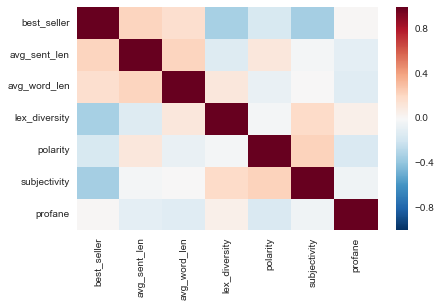

In [74]:
sns.heatmap(sf[['best_seller','avg_sent_len','avg_word_len','lex_diversity','polarity','subjectivity','profane']].corr())

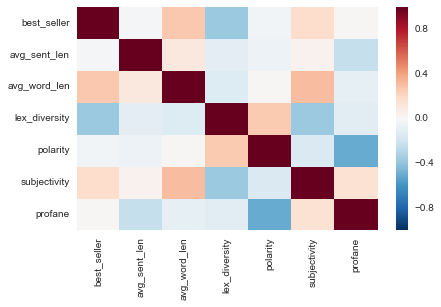

In [73]:
sns.heatmap(rm[['best_seller','avg_sent_len','avg_word_len','lex_diversity','polarity','subjectivity','profane']].corr())

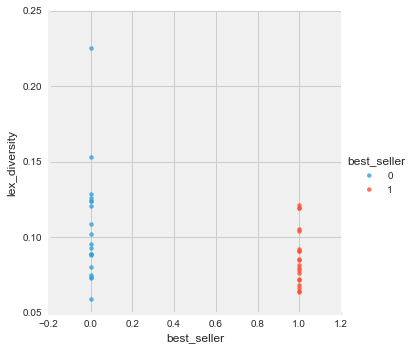

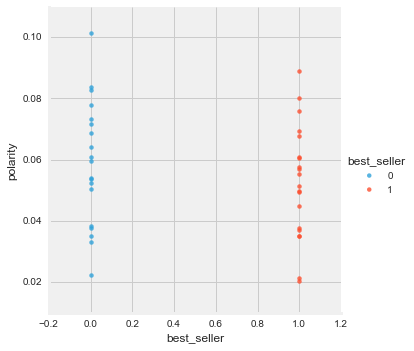

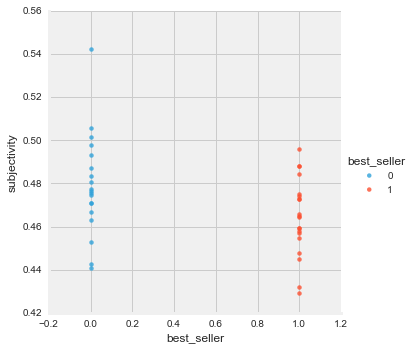

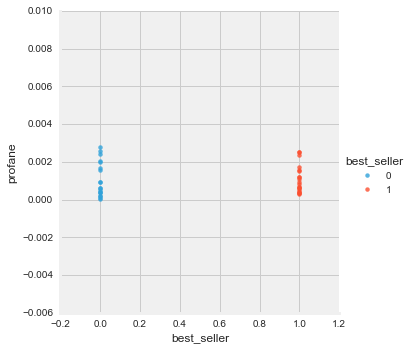

In [96]:
sns.lmplot(x='best_seller',y='lex_diversity',data=sf,hue='best_seller',fit_reg=False)
sns.lmplot(x='best_seller',y='polarity',data=sf,hue='best_seller',fit_reg=False)
sns.lmplot(x='best_seller',y='subjectivity',data=sf,hue='best_seller',fit_reg=False)
sns.lmplot(x='best_seller',y='profane',data=sf,hue='best_seller',fit_reg=False)

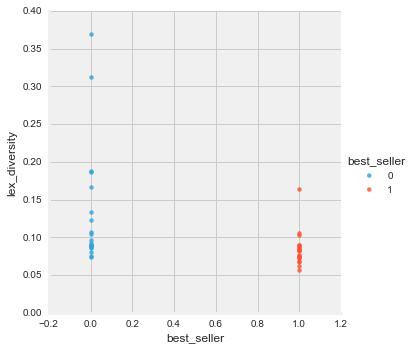

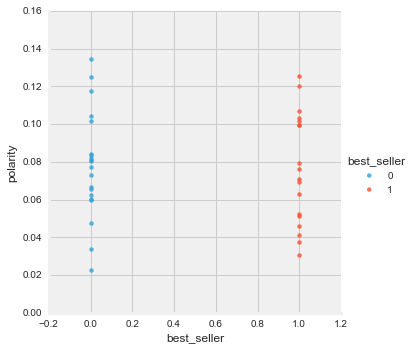

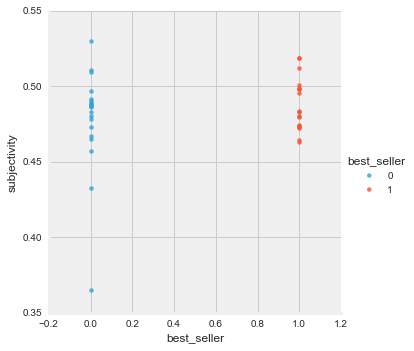

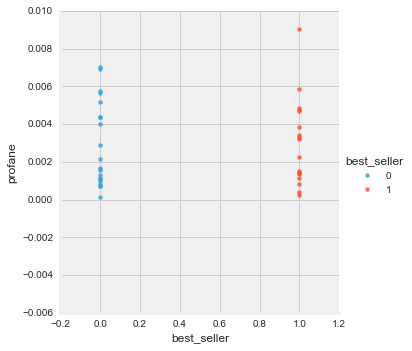

In [97]:
sns.lmplot(x='best_seller',y='lex_diversity',data=rm,hue='best_seller',fit_reg=False)
sns.lmplot(x='best_seller',y='polarity',data=rm,hue='best_seller',fit_reg=False)
sns.lmplot(x='best_seller',y='subjectivity',data=rm,hue='best_seller',fit_reg=False)
sns.lmplot(x='best_seller',y='profane',data=rm,hue='best_seller',fit_reg=False)

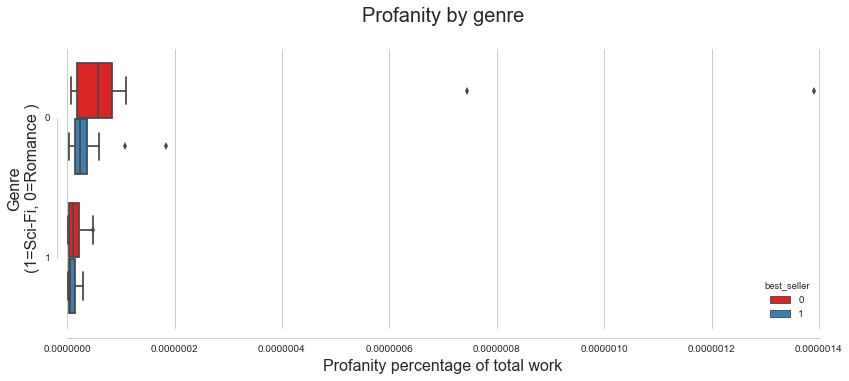

In [395]:
fig = plt.figure(figsize=(12,5))
sns.set_style("whitegrid")
sns.boxplot(x='profane', y="sci_fi", hue="best_seller", data=df, palette="Set1", orient='h',saturation=.9)
sns.despine(offset=10, trim=True)
plt.xlabel('Profanity percentage of total work', fontsize = 16)
plt.ylabel('Genre\n(1=Sci-Fi, 0=Romance )', fontsize = 16)
plt.title('Profanity by genre\n', fontsize = 20)
plt.show()

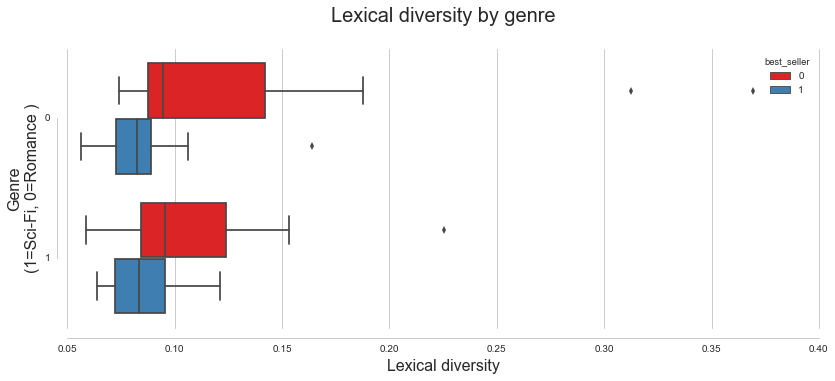

In [396]:
fig = plt.figure(figsize=(12,5))
sns.set_style("whitegrid")
sns.boxplot(x='lex_diversity', y="sci_fi", hue="best_seller", data=df, palette="Set1", orient='h',saturation=0.9)
sns.despine(offset=10, trim=True)
plt.xlabel('Lexical diversity', fontsize = 16)
plt.ylabel('Genre\n(1=Sci-Fi, 0=Romance )', fontsize = 16)
plt.title('Lexical diversity by genre\n', fontsize = 20)
plt.show()

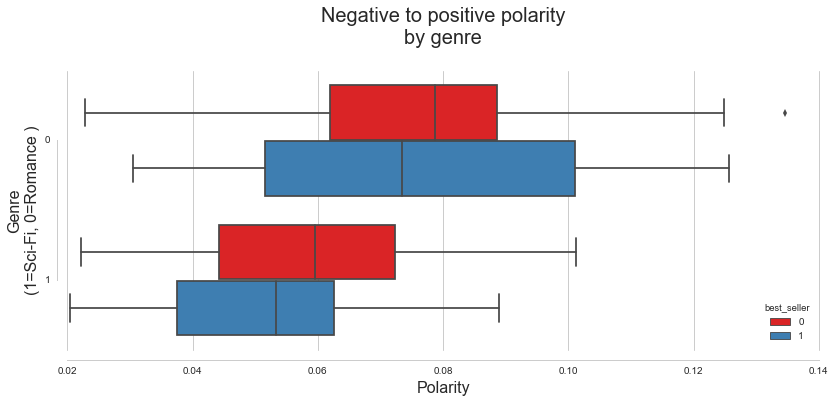

In [397]:
fig = plt.figure(figsize=(12,5))
sns.set_style("whitegrid")
sns.boxplot(x='polarity', y="sci_fi", hue="best_seller", data=df, palette="Set1", orient='h',saturation=0.9)
sns.despine(offset=10, trim=True)
plt.xlabel('Polarity', fontsize = 16)
plt.ylabel('Genre\n(1=Sci-Fi, 0=Romance )', fontsize = 16)
plt.title('Negative to positive polarity\nby genre\n', fontsize = 20)
plt.show()

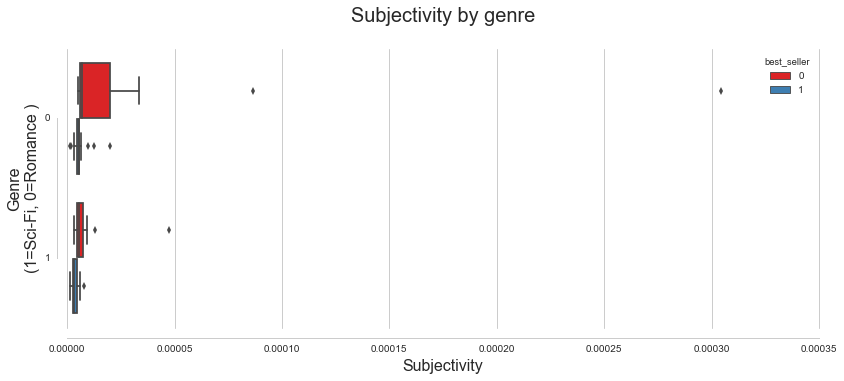

In [394]:
fig = plt.figure(figsize=(12,5))
sns.set_style("whitegrid")
sns.boxplot(x='subjectivity', y="sci_fi", hue="best_seller", data=df, palette="Set1", orient='h',saturation=0.9)
sns.despine(offset=10, trim=True)
plt.xlabel('Subjectivity', fontsize = 16)
plt.ylabel('Genre\n(1=Sci-Fi, 0=Romance )', fontsize = 16)
plt.title('Subjectivity by genre\n', fontsize = 20)
plt.show()

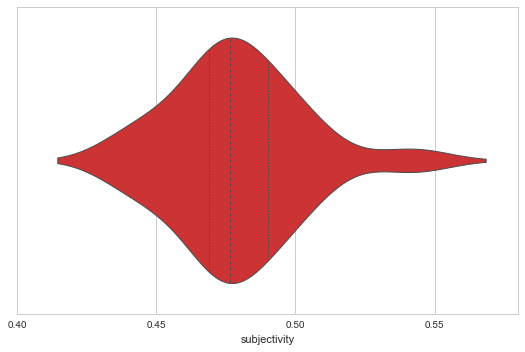

In [413]:
sns.set_style("whitegrid")
#sns.violinplot(data=sfbs,x='subjectivity',hue='sci_fi', palette="Set3", bw=.2, cut=1, linewidth=1,inner='quartile')

sns.violinplot(data=sff,x='subjectivity', palette="Set1",  linewidth=1,inner='quartile')

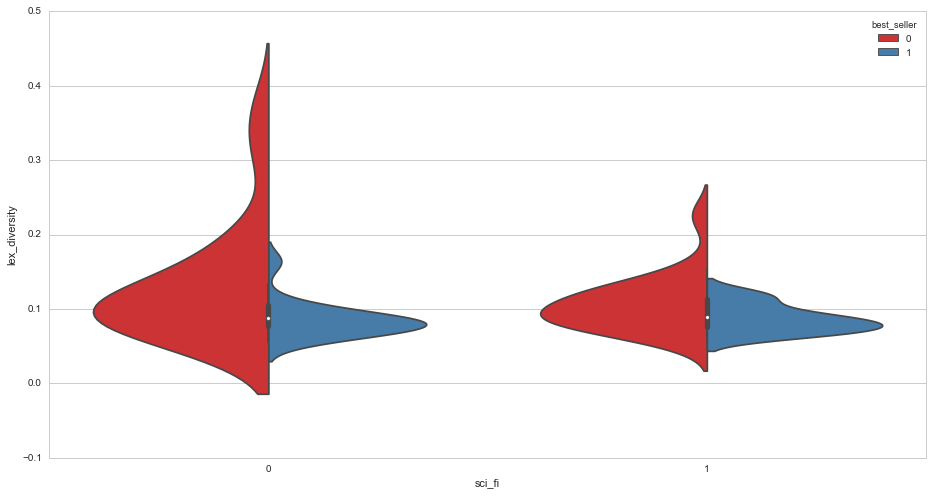

In [441]:
fig,ax = plt.subplots(figsize=(14,8))
ax = sns.violinplot(x="sci_fi", y="lex_diversity", hue="best_seller",
                    data=df, palette="Set1", split=True,scale="count", ax=ax)

plt.show()

### Important words and bi_/tri_grams

In [210]:
stop_words = text.ENGLISH_STOP_WORDS.union(['232'])
# remove character names
char_name_stop = stop_words.union(['awn','muad','dib','hock','seng','nell','pham','nuwen', 'enzo','anaander','mianaai',
                                   'rautha','feyd','willoughby','brandon','john','dashwood','jessica','fang','hiro',
                                  'steele','anastasia','rochester','jennings','ian','middleton','tara','jean','fairfax',
                                  'mcgraw','finkle', 'dearborne','dearbornes','peterby','anne','alice','henry','simon',
                                  'gavin','marco','bruce','catherine','nicky','brent','reverend','bene','gesserit','clef',
                                  'radch','kei',"sjandra",'goodbody','paul','robert','horza','ender','ruby','travis','dar',
                                  'miller','holden','travis','leto','mike','anna','justus','swan','jeff','onor','stilgar',
                                  'sam','jamie','sasha','riley','nerezza','christian','grey','ceo', 'enterprises','caroline',
                                  'grace','ivy','baron','rick','naomi','case','dinah','fassin','duke','yalson','closp','cliff',
                                  'michael','amos','jerry','slug','sai','hackworth','nelson','said','just','like','alec',
                                  'rosie','anderson','kanya','jaidee','isidore','sally','chuck','irene','jack','marcus','callie',
                                  'georgia','oliver','jenny','robinson','roderick','clubor','ellie','james','gideon','connor','matt',
                                  'alia','ghanima','balveda','kraiklyn','farad','hawat','ravna','ariekei','wahram','johanna','jefri',
                                  'seivarden','miri','emiko','dllenahkh','sadiri','ingrid','mandal','simone','yvonne','ajax','sara',
                                  'phipps','sharrock','miri','yvonne','allie','ginger','molly','bran','sawyer','ethan','whitey','ruban',
                                  'ferranti','lian','emiko','nasiha','joel','naveen'])

In [118]:
# initial feature review to see anything interesting

from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.feature_extraction import text 

vect = TfidfVectorizer(ngram_range=(1,1), stop_words=char_name_stop)

summaries_sfbs = "".join(sfbs['body'])
summaries_rmbs = "".join(rmbs['body'])
summaries_sff = "".join(sff['body'])
summaries_rmf = "".join(rmf['body'])
summaries_bs = "".join(bs['body'])
summaries_f = "".join(f['body'])

ngrams_summaries_sfbs = vect.build_analyzer()(summaries_sfbs)
ngrams_summaries_rmbs = vect.build_analyzer()(summaries_rmbs)
ngrams_summaries_sff = vect.build_analyzer()(summaries_sff)
ngrams_summaries_rmf = vect.build_analyzer()(summaries_rmf)
ngrams_summaries_bs = vect.build_analyzer()(summaries_bs)
ngrams_summaries_f = vect.build_analyzer()(summaries_f)

In [43]:
#Counter(ngrams_summaries_bs).most_common(50)

In [42]:
#Counter(ngrams_summaries_f).most_common(50)

In [121]:
# sci-fi books over-use character names
# also a long time ago, far far away
Counter(ngrams_summaries_sfbs).most_common(40)

[(u'said', 16618),
 (u'like', 8113),
 (u'just', 6633),
 (u'time', 5624),
 (u'know', 4966),
 (u'way', 4626),
 (u'people', 4198),
 (u'did', 3921),
 (u'looked', 3706),
 (u'little', 3406),
 (u'thought', 3386),
 (u'man', 3173),
 (u'think', 3159),
 (u'long', 3156),
 (u'away', 3147),
 (u'right', 3125),
 (u'going', 2930),
 (u'old', 2783),
 (u'got', 2766),
 (u'head', 2757),
 (u'came', 2643),
 (u'make', 2602),
 (u'good', 2564),
 (u'hand', 2540),
 (u'come', 2536),
 (u'look', 2490),
 (u'eyes', 2484),
 (u'new', 2477),
 (u'thing', 2454),
 (u'face', 2440),
 (u'asked', 2400),
 (u'things', 2275),
 (u'knew', 2218),
 (u'voice', 2194),
 (u'don', 2165),
 (u'place', 2112),
 (u'turned', 2102),
 (u'yes', 2015),
 (u'years', 2008),
 (u'saw', 2006)]

In [122]:
Counter(ngrams_summaries_sff).most_common(40)

[(u'said', 7688),
 (u'like', 4969),
 (u'just', 4137),
 (u'know', 3515),
 (u'time', 3271),
 (u'way', 2876),
 (u'dont', 2827),
 (u'did', 2484),
 (u'looked', 2433),
 (u'people', 2316),
 (u'im', 2309),
 (u'think', 2190),
 (u'didnt', 2174),
 (u'going', 2060),
 (u'right', 2029),
 (u'eyes', 2018),
 (u'head', 1989),
 (u'away', 1946),
 (u'little', 1850),
 (u'asked', 1818),
 (u'hand', 1784),
 (u'long', 1780),
 (u'ship', 1748),
 (u'look', 1745),
 (u'thought', 1679),
 (u'face', 1629),
 (u'good', 1619),
 (u'got', 1568),
 (u'say', 1551),
 (u'took', 1519),
 (u'came', 1506),
 (u'come', 1488),
 (u'man', 1483),
 (u'make', 1471),
 (u'want', 1455),
 (u'turned', 1454),
 (u'need', 1406),
 (u'knew', 1404),
 (u'moment', 1358),
 (u'tell', 1338)]

In [123]:
# romance titles have some classics --> deep breath, closed eyes, emotional gestures
Counter(ngrams_summaries_rmbs).most_common(40)

[(u'said', 11155),
 (u'like', 6119),
 (u'im', 5455),
 (u'know', 4830),
 (u'just', 4669),
 (u'dont', 4507),
 (u'time', 4320),
 (u'eyes', 4170),
 (u'hand', 3890),
 (u'didnt', 3754),
 (u'head', 3583),
 (u'want', 3551),
 (u'think', 3396),
 (u'did', 3230),
 (u'going', 3160),
 (u'face', 3118),
 (u'good', 3006),
 (u'way', 2982),
 (u'youre', 2914),
 (u'thought', 2852),
 (u'ye', 2789),
 (u'right', 2783),
 (u'asked', 2583),
 (u'away', 2530),
 (u'man', 2452),
 (u'looked', 2309),
 (u'little', 2266),
 (u'hands', 2228),
 (u'come', 2225),
 (u'ill', 2222),
 (u'long', 2179),
 (u'look', 2150),
 (u'wasnt', 2008),
 (u'door', 1999),
 (u'oh', 1998),
 (u'make', 1983),
 (u'say', 1971),
 (u'took', 1956),
 (u'thats', 1900),
 (u'need', 1875)]

In [124]:
Counter(ngrams_summaries_rmf).most_common(40)

[(u'like', 4187),
 (u'im', 3945),
 (u'just', 3394),
 (u'said', 3290),
 (u'know', 3181),
 (u'dont', 3177),
 (u'didnt', 2388),
 (u'want', 2349),
 (u'time', 2323),
 (u'eyes', 2231),
 (u'head', 2040),
 (u'right', 1896),
 (u'hand', 1882),
 (u'think', 1877),
 (u'did', 1818),
 (u'going', 1810),
 (u'way', 1747),
 (u'good', 1653),
 (u'face', 1622),
 (u'shed', 1589),
 (u'away', 1584),
 (u'look', 1551),
 (u'door', 1494),
 (u'youre', 1474),
 (u'hed', 1453),
 (u'say', 1438),
 (u'looked', 1402),
 (u'little', 1330),
 (u'come', 1320),
 (u'make', 1311),
 (u'got', 1259),
 (u'need', 1257),
 (u'thought', 1229),
 (u'night', 1221),
 (u'hands', 1192),
 (u'let', 1188),
 (u'wasnt', 1167),
 (u'tell', 1167),
 (u'room', 1152),
 (u'sure', 1132)]

In [153]:
vect = TfidfVectorizer(ngram_range=(2,3), stop_words=char_name_stop)

summaries_sfbs = "".join(sfbs['body'])
summaries_rmbs = "".join(rmbs['body'])
summaries_sff = "".join(sff['body'])
summaries_rmf = "".join(rmf['body'])
summaries_bs = "".join(bs['body'])
summaries_f = "".join(f['body'])

ngrams_summaries_sfbs = vect.build_analyzer()(summaries_sfbs)
ngrams_summaries_rmbs = vect.build_analyzer()(summaries_rmbs)
ngrams_summaries_sff = vect.build_analyzer()(summaries_sff)
ngrams_summaries_rmf = vect.build_analyzer()(summaries_rmf)
ngrams_summaries_bs = vect.build_analyzer()(summaries_bs)
ngrams_summaries_f = vect.build_analyzer()(summaries_f)

In [58]:
#Counter(ngrams_summaries_bs).most_common(40)

In [57]:
#Counter(ngrams_summaries_f).most_common(40)

In [154]:
Counter(ngrams_summaries_sfbs).most_common(50)

[(u'shook head', 456),
 (u'dont know', 393),
 (u'don know', 346),
 (u'long time', 314),
 (u'old man', 311),
 (u'years ago', 276),
 (u'white shirts', 241),
 (u'didnt know', 228),
 (u'thousand years', 206),
 (u'far away', 184),
 (u'cloud ark', 183),
 (u've got', 178),
 (u'dont think', 159),
 (u'didn know', 156),
 (u'did know', 151),
 (u'hong kong', 140),
 (u'don think', 137),
 (u'im sure', 137),
 (u'half hour', 132),
 (u'im going', 131),
 (u'don want', 130),
 (u'make sure', 126),
 (u'long ago', 126),
 (u'years old', 124),
 (u'shakes head', 124),
 (u'right hand', 122),
 (u'closed eyes', 122),
 (u'time time', 117),
 (u'half dozen', 116),
 (u'dont want', 104),
 (u'turned away', 103),
 (u'light years', 103),
 (u'little bit', 103),
 (u'year old', 102),
 (u'young man', 102),
 (u'deep breath', 101),
 (u'sort thing', 100),
 (u'left hand', 99),
 (u'fwi song', 97),
 (u'didnt want', 97),
 (u'quercer janath', 96),
 (u'inspector supervisor', 96),
 (u'yes sir', 90),
 (u'men women', 90),
 (u'voice came

In [155]:
Counter(ngrams_summaries_sff).most_common(50)

[(u'dont know', 572),
 (u'shook head', 344),
 (u'dont think', 248),
 (u'didnt know', 236),
 (u'im sorry', 205),
 (u'im sure', 192),
 (u'dont want', 179),
 (u'im going', 168),
 (u'long time', 150),
 (u'make sure', 142),
 (u'didnt want', 132),
 (u'deep breath', 122),
 (u'hell ship', 114),
 (u'years ago', 113),
 (u'old man', 110),
 (u'closed eyes', 108),
 (u'took deep', 104),
 (u'youre going', 104),
 (u'purple man', 100),
 (u'far away', 98),
 (u'explorer 410', 96),
 (u'took deep breath', 95),
 (u'want know', 87),
 (u'did know', 85),
 (u'diamond deep', 83),
 (u'purple men', 80),
 (u'ive got', 78),
 (u'dont worry', 75),
 (u'didnt think', 73),
 (u'young man', 69),
 (u'opened eyes', 68),
 (u'cheddite projector', 68),
 (u'leaned forward', 66),
 (u'dont need', 65),
 (u'ive seen', 65),
 (u'whats going', 65),
 (u'im glad', 65),
 (u'wasnt sure', 64),
 (u'know know', 64),
 (u'little bit', 64),
 (u'im afraid', 64),
 (u'weve got', 63),
 (u'time time', 63),
 (u'youre right', 62),
 (u'shakes head', 62)

In [158]:
# this is funnier
Counter(ngrams_summaries_rmbs).most_common(50)

[(u'dont know', 748),
 (u'shook head', 694),
 (u'im going', 617),
 (u'dont want', 570),
 (u'didnt know', 378),
 (u'dont think', 364),
 (u'im sorry', 355),
 (u'didnt want', 327),
 (u'im sure', 298),
 (u'deep breath', 276),
 (u'youre going', 247),
 (u'long time', 240),
 (u'closed eyes', 218),
 (u'blue eyes', 185),
 (u'new york', 177),
 (u'took deep', 174),
 (u'wasnt sure', 162),
 (u'living room', 161),
 (u'want know', 157),
 (u'took deep breath', 155),
 (u'shaking head', 145),
 (u'ive got', 144),
 (u'know youre', 132),
 (u'open door', 132),
 (u'im glad', 127),
 (u'oh god', 123),
 (u'little bit', 123),
 (u'ive seen', 120),
 (u'years ago', 115),
 (u'young man', 114),
 (u'make sure', 114),
 (u'didnt think', 113),
 (u'eyes closed', 113),
 (u'wasnt going', 113),
 (u'oh aye', 112),
 (u'dont need', 110),
 (u'youve got', 110),
 (u'know im', 109),
 (u'did know', 109),
 (u'oh yes', 108),
 (u'turned away', 107),
 (u'cell phone', 106),
 (u'think youre', 104),
 (u'dont worry', 103),
 (u'youre right',

In [159]:
Counter(ngrams_summaries_rmf).most_common(40)

[(u'dont know', 630),
 (u'dont want', 379),
 (u'shook head', 325),
 (u'im sorry', 303),
 (u'im going', 294),
 (u'didnt want', 288),
 (u'im sure', 250),
 (u'dont think', 243),
 (u'didnt know', 217),
 (u'living room', 147),
 (u'ive got', 144),
 (u'closed eyes', 138),
 (u'new york', 137),
 (u'parking lot', 133),
 (u'high school', 125),
 (u'make sure', 112),
 (u'wasnt sure', 110),
 (u'long time', 107),
 (u'opened door', 102),
 (u'know im', 101),
 (u'years ago', 100),
 (u'youre going', 100),
 (u'oh god', 98),
 (u'dont worry', 93),
 (u'deep breath', 92),
 (u'shakes head', 92),
 (u'im glad', 90),
 (u'youve got', 88),
 (u'think im', 86),
 (u'want know', 84),
 (u'rolled eyes', 81),
 (u'didnt think', 81),
 (u'youre right', 76),
 (u'im trying', 76),
 (u'held hand', 75),
 (u'dont need', 73),
 (u'let know', 73),
 (u'pulled away', 73),
 (u'know youre', 72),
 (u'ive seen', 71)]

## Topic modeling

It was my hope that n_grams and topic modeling would unveil a beautiful truth that best sellers present themes of exploration and journeying to the stars while flops are about alien-hate and interglactic corporate greed. But alas, it seems texts as varied as these are not well-suited for this stye of modeling.

Character names and dialogue "he said, she said, zorg said" were by far the most prevalent appearances. And after adding these to the stop words, what was left was not significant -- as evidenced by the tiny percentages.

Though if one were to make generalizations, 
- Romance best sellers have a high theme of body parts and I-statements: 

1|2|3
----|----|----
hand|know|im
im|america|eyes
ye|hand|face
hand|didnt|dont
ye|hand|eyes
know|eyes|going
dont|hand|im
im|eyes|know
im|hand|eyes

while their flop counterparts do not at all. I don't quite know what to do with this dominant topic: 

1|2|3
----|----|----
electricity|clucked|fallout

- Sci-Fi best sellers' topics revolve around time, people, and seem thoughtful 

1|2|3
----|----|----
steel|time|woodcarver
says|time|way
time|people|way
thought|fremen|man
know|time|people
time|people|way
dweller|time|looked

while the flops are quite similar but more "knowing" and less people focused:

1|2|3
----|----|----
great|know|time
know|time|way
way|dont|know
time|didnt|way
know|time|im


In [190]:
vect_sf1 = CountVectorizer(stop_words=char_name_stop)
X_sf1 = vect_sf1.fit_transform(sfbs['body'])
vocab_sf1 = {v: k for k, v in vect_sf1.vocabulary_.iteritems()}

lda_sf1 = models.LdaModel(
    matutils.Sparse2Corpus(X_sf1, documents_columns=False),
    num_topics  =  20,
    passes      =  5,
    id2word     =  vocab_sf1
)
lda_sf1.print_topics(num_topics=20, num_words=3)

[(0, u'0.006*steel + 0.004*time + 0.004*woodcarver'),
 (1, u'0.006*don + 0.006*know + 0.006*did'),
 (2, u'0.008*says + 0.004*time + 0.004*way'),
 (3, u'0.005*time + 0.004*people + 0.004*way'),
 (4, u'0.006*thought + 0.005*fremen + 0.005*man'),
 (5, u'0.003*time + 0.002*did + 0.002*know'),
 (6, u'0.002*time + 0.002*know + 0.002*little'),
 (7, u'0.002*know + 0.002*time + 0.002*people'),
 (8, u'0.005*looked + 0.004*know + 0.004*time'),
 (9, u'0.003*time + 0.003*people + 0.002*way'),
 (10, u'0.005*time + 0.004*little + 0.004*way'),
 (11, u'0.003*way + 0.002*time + 0.002*know'),
 (12, u'0.004*time + 0.003*looked + 0.003*way'),
 (13, u'0.003*know + 0.002*way + 0.002*time'),
 (14, u'0.003*time + 0.002*know + 0.002*way'),
 (15, u'0.005*know + 0.004*im + 0.004*time'),
 (16, u'0.005*dweller + 0.005*time + 0.005*looked'),
 (17, u'0.007*man + 0.005*white + 0.004*emiko'),
 (18, u'0.003*time + 0.003*know + 0.003*thought'),
 (19, u'0.006*molly + 0.004*know + 0.004*armitage')]

In [211]:
vect_sf0 = CountVectorizer(stop_words=char_name_stop)
X_sf0 = vect_sf0.fit_transform(sff['body'])
vocab_sf0 = {v: k for k, v in vect_sf0.vocabulary_.iteritems()}

lda_sf0 = models.LdaModel(
    matutils.Sparse2Corpus(X_sf0, documents_columns=False),
    num_topics  =  20,
    passes      =  5,
    id2word     =  vocab_sf0
)
lda_sf0.print_topics(num_topics=20, num_words=3)

[(0, u'0.010*men + 0.008*ship + 0.006*wes'),
 (1, u'0.002*dont + 0.002*know + 0.002*time'),
 (2, u'0.007*know + 0.007*people + 0.006*dont'),
 (3, u'0.005*great + 0.004*know + 0.004*time'),
 (4, u'0.005*know + 0.005*time + 0.004*way'),
 (5, u'0.002*way + 0.002*dont + 0.002*know'),
 (6, u'0.005*time + 0.005*didnt + 0.005*way'),
 (7, u'0.003*know + 0.003*time + 0.002*im'),
 (8, u'0.005*space + 0.004*time + 0.004*looked'),
 (9, u'0.005*ship + 0.004*know + 0.004*did'),
 (10, u'0.003*know + 0.003*way + 0.002*time'),
 (11, u'0.004*time + 0.003*dont + 0.003*way'),
 (12, u'0.002*looked + 0.002*did + 0.002*time'),
 (13, u'0.003*know + 0.003*looked + 0.002*time'),
 (14, u'0.003*time + 0.002*know + 0.002*way'),
 (15, u'0.003*know + 0.003*time + 0.002*dont'),
 (16, u'0.002*know + 0.002*looked + 0.002*way'),
 (17, u'0.009*whispr + 0.005*did + 0.004*time'),
 (18, u'0.002*know + 0.002*time + 0.002*way'),
 (19, u'0.003*did + 0.002*way + 0.002*know')]

In [201]:
vect_rm1 = CountVectorizer(stop_words=char_name_stop)
X_rm1 = vect_rm1.fit_transform(rmbs['body'])
vocab_rm1 = {v: k for k, v in vect_rm1.vocabulary_.iteritems()}

lda_rm1 = models.LdaModel(
    matutils.Sparse2Corpus(X_rm1, documents_columns=False),
    num_topics  =  20,
    passes      =  5,
    id2word     =  vocab_rm1
)
lda_rm1.print_topics(num_topics=20, num_words=3)

[(0, u'0.009*im + 0.007*dont + 0.006*know'),
 (1, u'0.012*luc + 0.006*didnt + 0.006*shed'),
 (2, u'0.004*hand + 0.004*know + 0.004*im'),
 (3, u'0.009*liss + 0.007*know + 0.006*knew'),
 (4, u'0.010*im + 0.009*america + 0.009*eyes'),
 (5, u'0.003*im + 0.003*know + 0.003*didnt'),
 (6, u'0.012*im + 0.008*want + 0.008*dont'),
 (7, u'0.009*ye + 0.004*hand + 0.004*face'),
 (8, u'0.008*know + 0.008*didnt + 0.007*time'),
 (9, u'0.004*hand + 0.003*didnt + 0.003*dont'),
 (10, u'0.007*ye + 0.006*hand + 0.005*eyes'),
 (11, u'0.010*didnt + 0.008*im + 0.008*going'),
 (12, u'0.007*time + 0.006*gene + 0.006*did'),
 (13, u'0.003*know + 0.003*eyes + 0.003*going'),
 (14, u'0.003*time + 0.003*did + 0.003*im'),
 (15, u'0.003*dont + 0.003*hand + 0.003*im'),
 (16, u'0.003*know + 0.002*hand + 0.002*going'),
 (17, u'0.004*im + 0.004*eyes + 0.003*know'),
 (18, u'0.008*bran + 0.007*sawyer + 0.006*know'),
 (19, u'0.003*im + 0.003*hand + 0.003*eyes')]

In [199]:
vect_rm0 = CountVectorizer(stop_words=char_name_stop)
X_rm0 = vect_rm0.fit_transform(rmf['body'])
vocab_rm0 = {v: k for k, v in vect_rm1.vocabulary_.iteritems()}

lda_rm0 = models.LdaModel(
    matutils.Sparse2Corpus(X_rm0, documents_columns=False),
    num_topics  =  20,
    passes      =  5,
    id2word     =  vocab_rm0
)
lda_rm0.print_topics(num_topics=20, num_words=3)

[(0, u'0.003*electricity + 0.003*clucked + 0.003*fallout'),
 (1, u'0.003*electricity + 0.003*clucked + 0.002*participated'),
 (2, u'0.018*electricity + 0.010*clucked + 0.009*participated'),
 (3, u'0.003*electricity + 0.003*clucked + 0.002*choral'),
 (4, u'0.007*choral + 0.006*fallout + 0.006*counterpoint'),
 (5, u'0.004*electricity + 0.003*fallout + 0.003*clucked'),
 (6, u'0.013*flirtations + 0.011*concerned + 0.008*fallout'),
 (7, u'0.003*clucked + 0.003*electricity + 0.002*fallout'),
 (8, u'0.010*electricity + 0.007*guidance + 0.006*clucked'),
 (9, u'0.010*fluke + 0.009*bain + 0.007*learns'),
 (10, u'0.025*forgone + 0.011*exhibiting + 0.011*anymorenor'),
 (11, u'0.004*electricity + 0.004*clucked + 0.003*fallout'),
 (12, u'0.008*electricity + 0.007*clucked + 0.006*fallout'),
 (13, u'0.005*electricity + 0.004*fallout + 0.003*choral'),
 (14, u'0.013*laces + 0.012*feat + 0.007*learns'),
 (15, u'0.004*clucked + 0.004*electricity + 0.003*fallout'),
 (16, u'0.003*clucked + 0.003*electricity

In [277]:
pos = df.groupby(['best_seller','sci_fi'])[['conj_coord', 'number', 'determiner', 'exist_there', 'foreign_word',
       'conj_sub_prep', 'adj', 'adj_compare', 'adj_sup', 'verb_aux',
       'noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm',
       'pronoun_pers', 'pronoun_poss', 'adv', 'adv_compare', 'adv_sup',
       'adv_part', 'inf_to', 'interject', 'verb_base', 'verb_past',
       'verb_ger', 'verb_pp', 'verb_sing_pres', 'verb_3rd_sing_pres',
       'wh_determ', 'wh_pronoun', 'wh_poss', 'wh_adv', 'poss_ending',
       'symbol']].apply(np.mean).reset_index()

In [275]:
pos_diff = pd.DataFrame(columns=['conj_coord', 'number', 'determiner', 'exist_there', 'foreign_word',
       'conj_sub_prep', 'adj', 'adj_compare', 'adj_sup', 'verb_aux',
       'noun', 'noun_prop', 'noun_prop_pural', 'noun_plural', 'predeterm',
       'pronoun_pers', 'pronoun_poss', 'adv', 'adv_compare', 'adv_sup',
       'adv_part', 'inf_to', 'interject', 'verb_base', 'verb_past',
       'verb_ger', 'verb_pp', 'verb_sing_pres', 'verb_3rd_sing_pres',
       'wh_determ', 'wh_pronoun', 'wh_poss', 'wh_adv', 'poss_ending',
       'symbol'])



In [274]:
for col in range(1,len(pos.columns)):
    pos.loc[1,col] = (pos.iloc[1,col] - pos.iloc[0,col])
pos_diff.head()

,conj_coord,number,determiner,exist_there,foreign_word,conj_sub_prep,adj,adj_compare,adj_sup,verb_aux,...,26,27,28,29,30,31,32,33,34,35
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000349,0.001573,-0.003259,0.000171,0.000187,-0.000018,0.000025,-0.000234,0.00167,0.000001


In [268]:
pos_diff['conj_coord'] = 0

In [278]:
pos

,best_seller,sci_fi,conj_coord,number,determiner,exist_there,foreign_word,conj_sub_prep,adj,adj_compare,...,verb_ger,verb_pp,verb_sing_pres,verb_3rd_sing_pres,wh_determ,wh_pronoun,wh_poss,wh_adv,poss_ending,symbol
0,0,0,0.034082,0.005180,0.080646,0.001251,0.000084,0.105390,0.052324,0.002201,...,0.023675,0.017599,0.028854,0.016468,0.002470,0.005481,0.000061,0.007035,0.000666,0.000000e+00
1,0,1,0.035925,0.006107,0.099968,0.002262,0.000072,0.109104,0.059757,0.003002,...,0.023674,0.020703,0.023068,0.013017,0.003557,0.005563,0.000067,0.005889,0.000394,0.000000e+00
2,1,0,0.035774,0.005833,0.081977,0.001664,0.000106,0.105748,0.053471,0.002546,...,0.026286,0.018071,0.026519,0.013923,0.002468,0.005668,0.000070,0.006726,0.000730,7.351536e-07
3,1,1,0.034273,0.007670,0.101088,0.002412,0.000138,0.111860,0.063224,0.002836,...,0.021988,0.023037,0.019407,0.015889,0.003832,0.005356,0.000105,0.005808,0.003530,1.892687e-06


In [292]:
df.head()

,best_seller,body,sci_fi,title,avg_sent_len,word_count,avg_word_len,lex_diversity,polarity,subjectivity,...,verb_pp,verb_sing_pres,verb_3rd_sing_pres,wh_determ,wh_pronoun,wh_poss,wh_adv,poss_ending,symbol,list_marker
0,1,Prologue The sun is always just about to ris...,1,2312 - kim stanley robinson,14,166265,4,0.090717,0.076000,0.000003,...,0.023553,0.019427,0.010706,0.004228,0.004685,0.000024,0.005545,0.000000,0.000000,0.0
1,1,How to explain? How to describe? Even the omni...,1,a fire upon the deep - vernor vinge,11,207548,4,0.064477,0.067722,0.000002,...,0.024602,0.015018,0.011385,0.003941,0.004240,0.000043,0.004809,0.008716,0.000005,0.0
2,1,"The body lay naked and facedown, a deathly gr...",1,ancillary justice - ann leckie,11,108263,4,0.079815,0.035025,0.000004,...,0.027618,0.021937,0.008729,0.003510,0.007011,0.000083,0.007001,0.000000,0.000000,0.0
3,1,Children of Dune Frank Herbert Muad'D...,1,children of dune - frank herbert,11,151352,4,0.076094,0.057704,0.000003,...,0.024863,0.019650,0.014014,0.005781,0.005821,0.000231,0.006878,0.006548,0.000033,0.0
4,1,Consider Phlebas Iain Banks Idolatry is wor...,1,consider phlebas - iain m banks,14,176337,4,0.064042,0.035018,0.000003,...,0.022083,0.013259,0.006987,0.002943,0.004798,0.000051,0.005036,0.006805,0.000000,0.0
